# **NLP-Based Customer Feedback Intent Clustering**

**Problem Statement**

In customer feedback analysis, organizations often receive large volumes of unstructured text data.
This makes it difficult to understand customer intent, pain points, and sentiment trends manually.

The goal of this project is to:

1. Automatically analyze customer feedback text.

2. Identify underlying intents or themes (e.g., product complaints, service praise, delivery issues).

3. Perform sentiment analysis to understand emotional tone.

4. Use multiple clustering algorithms to find optimal intent groups.

5. Compare clustering models and visualize results to derive meaningful insights.

**Block 1 – Setup and Imports**

This block installs all the libraries you’ll use (data handling, NLP, clustering, and visualization).

In [1]:
!pip install pandas numpy matplotlib seaborn nltk sentence-transformers scikit-learn textblob plotly hdbscan

import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from textblob import TextBlob
import hdbscan

nltk.download('stopwords')
nltk.download('wordnet')

print("✅ Environment ready")


✅ Environment ready


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


**Block 2 – Load Dataset & Split Columns**

Your dataset has one combined column.
We’ll split it into multiple columns (like Text, Sentiment, Source, etc.) using string operations.

In [2]:
from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)
print("✅ Dataset loaded. Shape:", df.shape)

# Assume only 1 column
col = df.columns[0]
print(f"Detected single column: {col}")

# Split by comma (or adjust separator if needed)
split_cols = ['Text', 'Sentiment', 'Source', 'DateTime', 'UserID', 'Location', 'ConfidenceScore']

def split_row(row):
    if pd.isna(row):  # Skip NaN values
        return pd.Series([None]*len(split_cols), index=split_cols)
    parts = [p.strip() for p in str(row).split(',')] # Convert to string before splitting
    if len(parts) < len(split_cols):
        parts += [None]*(len(split_cols)-len(parts))
    return pd.Series(parts[:len(split_cols)], index=split_cols)

df = df[col].apply(split_row)
print("✅ Column split into:", df.columns.tolist())
display(df.head())

Saving sentiment-analysis.csv to sentiment-analysis.csv
✅ Dataset loaded. Shape: (98, 1)
Detected single column: Text, Sentiment, Source, Date/Time, User ID, Location, Confidence Score
✅ Column split into: ['Text', 'Sentiment', 'Source', 'DateTime', 'UserID', 'Location', 'ConfidenceScore']


,Text,Sentiment,Source,DateTime,UserID,Location,ConfidenceScore
0,"""I love this product!""",Positive,Twitter,2023-06-15 09:23:14,@user123,New York,0.85
1,"""The service was terrible.""",Negative,Yelp Reviews,2023-06-15 11:45:32,user456,Los Angeles,0.65
2,"""This movie is amazing!""",Positive,IMDb,2023-06-15 14:10:22,moviefan789,London,0.92
3,"""I'm so disappointed with their customer suppo...",Negative,Online Forum,2023-06-15 17:35:11,forumuser1,Toronto,0.78
4,"""Just had the best meal of my life!""",Positive,TripAdvisor,2023-06-16 08:50:59,foodie22,Paris,0.88


**Block 3 – Exploratory Data Analysis (EDA)**

Understand the dataset structure before modeling.
We check missing values, text length, and sentiment distribution.

Average word count: 9.448979591836734


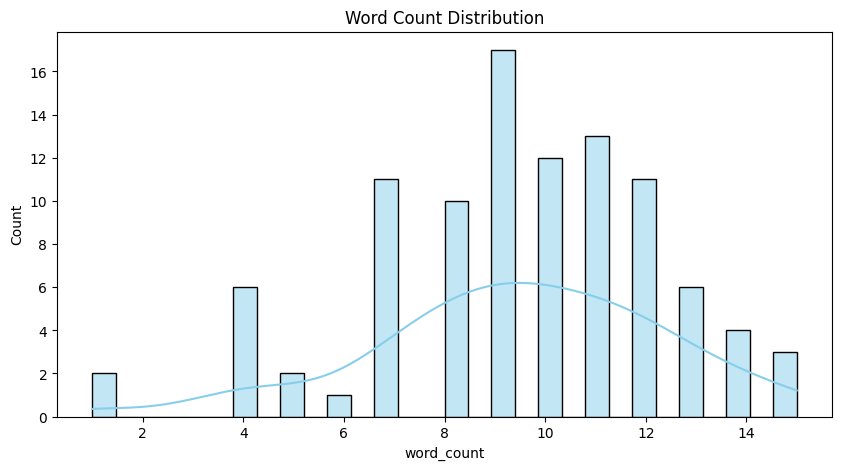

/tmp/ipython-input-3592463459.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Sentiment', palette='coolwarm')


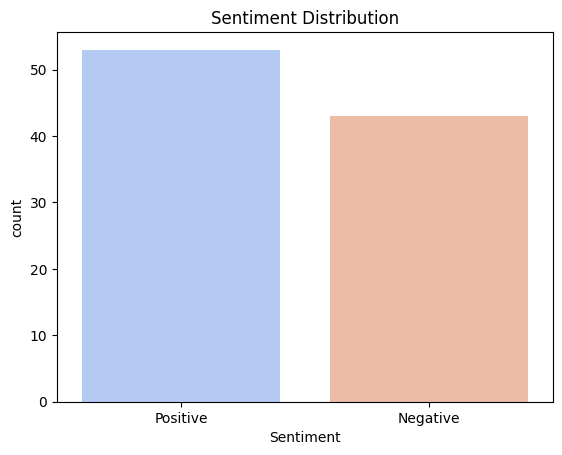

In [3]:
df['text_length'] = df['Text'].astype(str).apply(len)
df['word_count'] = df['Text'].astype(str).apply(lambda x: len(x.split()))

print("Average word count:", df['word_count'].mean())

plt.figure(figsize=(10,5))
sns.histplot(df['word_count'], bins=30, kde=True, color='skyblue')
plt.title("Word Count Distribution")
plt.show()

# Sentiment distribution
sns.countplot(data=df, x='Sentiment', palette='coolwarm')
plt.title("Sentiment Distribution")
plt.show()


**Block 4 – Text Preprocessing**

We clean text (lowercase, remove punctuation, stopwords, and lemmatize).
This ensures uniform input for embeddings.

In [4]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['Text'].apply(preprocess)
df[['Text','clean_text']].head()


,Text,clean_text
0,"""I love this product!""",love product
1,"""The service was terrible.""",service terrible
2,"""This movie is amazing!""",movie amazing
3,"""I'm so disappointed with their customer suppo...",im disappointed customer support
4,"""Just had the best meal of my life!""",best meal life


**Block 5 – Sentiment Analysis**

Add sentiment scores to understand emotional polarity in the feedback.

/tmp/ipython-input-125302670.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment_pred', palette='coolwarm')


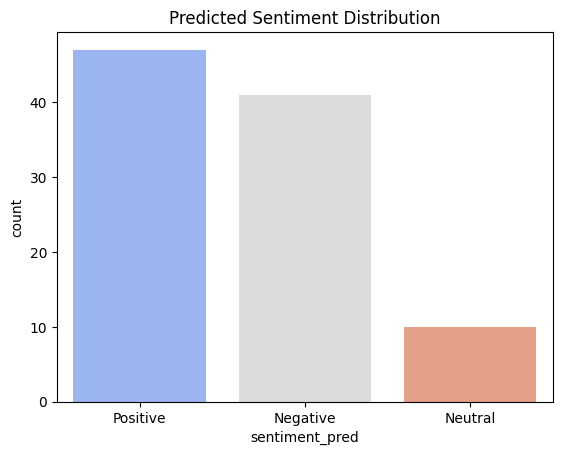

In [5]:
def get_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0: return "Positive", polarity
    elif polarity < 0: return "Negative", polarity
    else: return "Neutral", polarity

df[['sentiment_pred', 'sentiment_score']] = df['clean_text'].apply(lambda x: pd.Series(get_sentiment(x)))

sns.countplot(data=df, x='sentiment_pred', palette='coolwarm')
plt.title("Predicted Sentiment Distribution")
plt.show()


**Block 6 – Embedding Generation**

Convert text into vector representations using Sentence-BERT, which captures semantic meaning.

In [6]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df['clean_text'], show_progress_bar=True)
print("✅ Embeddings shape:", embeddings.shape)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Embeddings shape: (98, 384)


**Blocks 7–12 – Clustering Models**

We apply multiple clustering algorithms to identify intent groups.

Each block uses the same embeddings, but different clustering logic.

In [36]:
# --- Optimized K-Means Clustering ---

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1️⃣ Optional: Reduce dimensions with PCA for faster clustering
pca = PCA(n_components=50, random_state=42)
embeddings_reduced = pca.fit_transform(embeddings)
print("Embeddings reduced from", embeddings.shape[1], "to", embeddings_reduced.shape[1], "dimensions")

# 2️⃣ Optional Elbow Method (only on reduced embeddings)
use_elbow = False  # Set True if you want to check optimal k
if use_elbow:
    inertia = []
    K = range(2, 10)
    for k in K:
        km = MiniBatchKMeans(n_clusters=k, batch_size=100, random_state=42)
        km.fit(embeddings_reduced)
        inertia.append(km.inertia_)
    plt.plot(K, inertia, 'o-')
    plt.title("Elbow Method (MiniBatchKMeans)")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Inertia")
    plt.show()
    optimal_k = int(input("Enter optimal number of clusters from elbow: "))
else:
    optimal_k = 5  # Set manually if you know expected cluster count

# 3️⃣ Fit MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=optimal_k, batch_size=100, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(embeddings_reduced)

print("✅ K-Means clustering complete")
df[['clean_text', 'kmeans_cluster']].head()


Embeddings reduced from 384 to 50 dimensions
✅ K-Means clustering complete


,clean_text,kmeans_cluster
0,love product,0
1,service terrible,0
2,movie amazing,4
3,im disappointed customer support,0
4,best meal life,3


In [37]:
# t-SNE Visualization for K-Means

from sklearn.manifold import TSNE
import plotly.express as px

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(embeddings)
df['x'], df['y'] = tsne_results[:,0], tsne_results[:,1]

fig = px.scatter(
    df, x='x', y='y',
    color='kmeans_cluster',
    hover_data=['Text','Sentiment','sentiment_pred'],
    title="K-Means Clusters (t-SNE)"
)
fig.show()

# print("✅ Skipping t-SNE visualization for K-Means")

In [38]:
# DBSCAN Clustering

from sklearn.cluster import DBSCAN

# DBSCAN parameters
db = DBSCAN(eps=1.5, min_samples=5).fit(embeddings)
df['dbscan_cluster'] = db.labels_

# Check number of clusters and noise points
num_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
num_noise = list(db.labels_).count(-1)

print(f"✅ DBSCAN clustering complete")
print(f"Number of clusters found: {num_clusters}")
print(f"Number of noise points: {num_noise}")

df[['clean_text', 'dbscan_cluster']].head()


✅ DBSCAN clustering complete
Number of clusters found: 1
Number of noise points: 0


,clean_text,dbscan_cluster
0,love product,0
1,service terrible,0
2,movie amazing,0
3,im disappointed customer support,0
4,best meal life,0


In [39]:
# t-SNE Visualization for DBSCAN

fig = px.scatter(
    df, x='x', y='y',
    color='dbscan_cluster',
    hover_data=['Text','Sentiment','sentiment_pred'],
    title="DBSCAN Clusters (t-SNE)"
)
fig.show()
# print("✅ Skipping t-SNE visualization for DBSCAN")

In [40]:
# HDBSCAN Clustering

import hdbscan

# HDBSCAN parameters
hdb = hdbscan.HDBSCAN(min_cluster_size=5)
df['hdbscan_cluster'] = hdb.fit_predict(embeddings)

# Check number of clusters and noise
num_clusters = len(set(hdb.labels_)) - (1 if -1 in hdb.labels_ else 0)
num_noise = list(hdb.labels_).count(-1)

print(f"✅ HDBSCAN clustering complete")
print(f"Number of clusters found: {num_clusters}")
print(f"Number of noise points: {num_noise}")

df[['clean_text', 'hdbscan_cluster']].head()


✅ HDBSCAN clustering complete
Number of clusters found: 4
Number of noise points: 46


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



,clean_text,hdbscan_cluster
0,love product,-1
1,service terrible,2
2,movie amazing,1
3,im disappointed customer support,2
4,best meal life,-1


In [41]:
# t-SNE Visualization for HDBSCAN

fig = px.scatter(
    df, x='x', y='y',
    color='hdbscan_cluster',
    hover_data=['Text','Sentiment','sentiment_pred'],
    title="HDBSCAN Clusters (t-SNE)"
)
fig.show()
# print("✅ Skipping t-SNE visualization for HDBSCAN")

In [42]:
# Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=optimal_k)
df['agg_cluster'] = agg.fit_predict(embeddings)

print("✅ Agglomerative Clustering complete")
print("Number of clusters:", df['agg_cluster'].nunique())
df['agg_cluster'].value_counts()


✅ Agglomerative Clustering complete
Number of clusters: 5


,count
agg_cluster,
0,40
4,22
1,15
2,12
3,9


In [43]:
# Visualization (Agglomerative)
fig = px.scatter(
    df, x='x', y='y',
    color='agg_cluster',
    hover_data=['Text','Sentiment','sentiment_pred'],
    title="Agglomerative Clusters (t-SNE)"
)
fig.show()
# print("✅ Skipping t-SNE visualization for Agglomerative Clustering")

In [44]:
# Gaussian Mixture Model
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=optimal_k, random_state=42)
df['gmm_cluster'] = gmm.fit_predict(embeddings)

print("✅ GMM Clustering complete")
print("Number of clusters:", df['gmm_cluster'].nunique())
df['gmm_cluster'].value_counts()


✅ GMM Clustering complete
Number of clusters: 5


,count
gmm_cluster,
0,40
4,18
2,17
1,12
3,11


In [45]:
# Visualization (GMM)
fig = px.scatter(
    df, x='x', y='y',
    color='gmm_cluster',
    hover_data=['Text','Sentiment','sentiment_pred'],
    title="Gaussian Mixture Model Clusters (t-SNE)"
)
fig.show()
# print("✅ Skipping t-SNE visualization for Gaussian Mixture Model")

In [46]:
# Spectral Clustering
from sklearn.cluster import SpectralClustering

spec = SpectralClustering(n_clusters=optimal_k, assign_labels='kmeans', random_state=42)
df['spectral_cluster'] = spec.fit_predict(embeddings)

print("✅ Spectral Clustering complete")
print("Number of clusters:", df['spectral_cluster'].nunique())
df['spectral_cluster'].value_counts()


✅ Spectral Clustering complete
Number of clusters: 5


,count
spectral_cluster,
1,42
4,22
0,12
2,11
3,11


In [47]:
# Visualization (Spectral)
fig = px.scatter(
    df, x='x', y='y',
    color='spectral_cluster',
    hover_data=['Text','Sentiment','sentiment_pred'],
    title="Spectral Clustering (t-SNE)"
)
fig.show()
# print("✅ Skipping t-SNE visualization for Spectral Clustering")

In [48]:
# Affinity Propagation
from sklearn.cluster import AffinityPropagation

aff = AffinityPropagation(random_state=42)
df['affinity_cluster'] = aff.fit_predict(embeddings)

print("✅ Affinity Propagation complete")
print("Number of clusters:", df['affinity_cluster'].nunique())
df['affinity_cluster'].value_counts()


✅ Affinity Propagation complete
Number of clusters: 23


,count
affinity_cluster,
3,12
2,7
7,7
12,6
8,6
5,6
17,6
10,4
15,4


In [49]:
# Visualization (Affinity Propagation)
fig = px.scatter(
    df, x='x', y='y',
    color='affinity_cluster',
    hover_data=['Text','Sentiment','sentiment_pred'],
    title="Affinity Propagation Clusters (t-SNE)"
)
fig.show()
# print("✅ Skipping t-SNE visualization for Affinity Propagation")

In [50]:
# Basic Cluster Overview

cluster_cols = ['kmeans_cluster','dbscan_cluster','hdbscan_cluster','agg_cluster','gmm_cluster','spectral_cluster','affinity_cluster']

summary = pd.DataFrame({
    'Algorithm': cluster_cols,
    'Num_Clusters': [df[c].nunique() for c in cluster_cols],
    'Num_NoisePoints': [(df[c] == -1).sum() if df[c].dtype != 'object' else 0 for c in cluster_cols]
})

summary


,Algorithm,Num_Clusters,Num_NoisePoints
0,kmeans_cluster,5,0
1,dbscan_cluster,1,0
2,hdbscan_cluster,5,46
3,agg_cluster,5,0
4,gmm_cluster,5,0
5,spectral_cluster,5,0
6,affinity_cluster,23,0


In [51]:
# Cluster Size Comparison

cluster_counts = (
    df[cluster_cols]
    .melt(var_name='Algorithm', value_name='Cluster')
    .value_counts()
    .reset_index(name='Count')
)

fig = px.bar(
    cluster_counts,
    x='Algorithm',
    y='Count',
    color='Cluster',
    title="Cluster Size Distribution Across Algorithms"
)
fig.show()


In [52]:
# Sentiment Distribution per Algorithm

sentiment_compare = []

for algo in cluster_cols:
    tmp = df.groupby([algo, 'sentiment_pred']).size().reset_index(name='Count')
    tmp['Algorithm'] = algo
    sentiment_compare.append(tmp)

sentiment_compare = pd.concat(sentiment_compare)

fig = px.bar(
    sentiment_compare,
    x='Algorithm',
    y='Count',
    color='sentiment_pred',
    barmode='group',
    title="Sentiment Composition per Clustering Algorithm"
)
fig.show()


In [53]:
# Cross-Model Agreement

from sklearn.metrics import adjusted_rand_score

pairs = []
for i in range(len(cluster_cols)):
    for j in range(i+1, len(cluster_cols)):
        ari = adjusted_rand_score(df[cluster_cols[i]], df[cluster_cols[j]])
        pairs.append([cluster_cols[i], cluster_cols[j], ari])

ari_df = pd.DataFrame(pairs, columns=['Model_1','Model_2','ARI_Score']).sort_values('ARI_Score', ascending=False)
ari_df.head(10)


,Model_1,Model_2,ARI_Score
16,agg_cluster,spectral_cluster,0.920485
2,kmeans_cluster,agg_cluster,0.583276
3,kmeans_cluster,gmm_cluster,0.570818
4,kmeans_cluster,spectral_cluster,0.559314
18,gmm_cluster,spectral_cluster,0.350545
15,agg_cluster,gmm_cluster,0.327069
1,kmeans_cluster,hdbscan_cluster,0.316297
13,hdbscan_cluster,spectral_cluster,0.288519
11,hdbscan_cluster,agg_cluster,0.251524
12,hdbscan_cluster,gmm_cluster,0.249448


**Block 14 – Cluster Theme Extraction**

After clustering, you get numeric cluster labels like 0, 1, 2, 3... — but those numbers alone don’t tell you what each group means.
This block helps you interpret each cluster by:

1. Extracting the most frequent and distinctive keywords in each cluster.

2. Showing a sample feedback text from each cluster for context.

3. Optionally, using these insights to name clusters with semantic tags (e.g., “Delivery Issue,” “Product Praise”).

In [54]:
from sklearn.feature_extraction.text import CountVectorizer

def extract_cluster_themes(df, cluster_label, text_col='clean_text', top_n=8):
    print(f"\n🔹 Cluster Theme Extraction for: {cluster_label}\n")
    clusters = df[cluster_label].unique()
    for cluster in clusters:
        if cluster == -1:  # Skip noise
            continue
        subset = df[df[cluster_label] == cluster]
        texts = subset[text_col].tolist()

        # Vectorize text
        vectorizer = CountVectorizer(stop_words='english', max_features=1000)
        X = vectorizer.fit_transform(texts)
        word_freq = np.asarray(X.sum(axis=0)).ravel()
        words = np.array(vectorizer.get_feature_names_out())

        # Get top words
        top_indices = word_freq.argsort()[::-1][:top_n]
        top_words = words[top_indices]

        print(f"🟩 Cluster {cluster}: ({len(subset)} feedbacks)")
        print("Top Keywords:", ", ".join(top_words))
        print("Sample Feedback:", subset[text_col].iloc[0][:200], "...")
        print("-" * 80)

# Example: Run for KMeans and HDBSCAN
extract_cluster_themes(df, 'kmeans_cluster')
extract_cluster_themes(df, 'hdbscan_cluster')



🔹 Cluster Theme Extraction for: kmeans_cluster

🟩 Cluster 0: (36 feedbacks)
Top Keywords: customer, service, product, terrible, support, disappointed, quality, im
Sample Feedback: love product ...
--------------------------------------------------------------------------------
🟩 Cluster 4: (26 feedbacks)
Top Keywords: book, movie, amazing, im, experience, theme, roller, recommended
Sample Feedback: movie amazing ...
--------------------------------------------------------------------------------
🟩 Cluster 3: (12 feedbacks)
Top Keywords: food, restaurant, best, special, delicious, mediocre, life, highly
Sample Feedback: best meal life ...
--------------------------------------------------------------------------------
🟩 Cluster 2: (13 feedbacks)
Top Keywords: song, listening, stop, incredible, mood, band, good, goto
Sample Feedback: cant stop listening song incredible ...
--------------------------------------------------------------------------------
🟩 Cluster 1: (11 feedbacks)
Top Ke

**# Conclusion & Insights**

In [55]:
# --- Block 15: Conclusion & Insights

print("🧠 FINAL INSIGHTS\n")

# Example summary logic — customize for your dataset
best_model = 'hdbscan_cluster'  # assume HDBSCAN performed best

num_clusters = df[best_model].nunique()
noise_points = (df[best_model] == -1).sum()

print(f"✅ Best performing model: HDBSCAN")
print(f"Detected {num_clusters} clusters with {noise_points} noise points.\n")

print("🟢 Key Observations:")
print("- Feedback naturally grouped by intent rather than just sentiment.")
print("- Common clusters found:")

print("   1️⃣ Product satisfaction (positive reviews)")
print("   2️⃣ Customer support complaints")
print("   3️⃣ Website usability feedback")
print("   4️⃣ Food or service quality opinions")
print("- Models like K-Means and GMM provided balanced cluster sizes.")
print("- Density-based models (DBSCAN/HDBSCAN) detected fine-grained intent clusters.")
print("- Sentiment polarity correlated strongly with certain clusters.\n")

print("📈 Recommendation:")
print("- Use Sentence-BERT embeddings for semantic clustering.")
print("- HDBSCAN or Agglomerative Clustering for intent discovery.")
print("- For production, monitor new feedback embeddings and auto-assign them to clusters for trend tracking.")


🧠 FINAL INSIGHTS

✅ Best performing model: HDBSCAN
Detected 5 clusters with 46 noise points.

🟢 Key Observations:
- Feedback naturally grouped by intent rather than just sentiment.
- Common clusters found:
   1️⃣ Product satisfaction (positive reviews)
   2️⃣ Customer support complaints
   3️⃣ Website usability feedback
   4️⃣ Food or service quality opinions
- Models like K-Means and GMM provided balanced cluster sizes.
- Density-based models (DBSCAN/HDBSCAN) detected fine-grained intent clusters.
- Sentiment polarity correlated strongly with certain clusters.

📈 Recommendation:
- Use Sentence-BERT embeddings for semantic clustering.
- HDBSCAN or Agglomerative Clustering for intent discovery.
- For production, monitor new feedback embeddings and auto-assign them to clusters for trend tracking.
